In [1]:
from theory import *

In [2]:
import numpy as np
from torch_geometric.datasets import Planetoid
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.utils import to_dense_adj, get_laplacian
from scipy import linalg
import seaborn as sbs

In [3]:
def print_dataset_info(dataset):
    print("Number of connected graph:", len(dataset))
    print("Number of classes:", dataset.num_classes)
    print("Number of features:", dataset.num_node_features)
    graph = dataset[0]
    print("Number of edges:", graph.edge_index.size(1)//2)
    print("Number of ndoes:", graph.x.size(0))
    print("Number of train nodes:", graph.train_mask.sum().item())
    print("Number of test nodes:", graph.test_mask.sum().item())
    print("Number of val nodes:", graph.val_mask.sum().item())
    print("Is undirected graph:", graph.is_undirected())

In [4]:
dataset = Planetoid(root='../dataset/Cora', name='Cora')
print_dataset_info(dataset)
graph = dataset[0]

Number of connected graph: 1
Number of classes: 7
Number of features: 1433
Number of edges: 5278
Number of ndoes: 2708
Number of train nodes: 140
Number of test nodes: 1000
Number of val nodes: 500
Is undirected graph: True


In [5]:
def pca_features(graph, n_components=8):
    # PCA transform the sparse features
    X = graph.x.numpy()
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

def scatter_plot_pca(X_pca, y):
    plt.figure(figsize=(10, 8))
    plt.scatter(x=X_pca[:,0], y=X_pca[:,1], c=y)
    plt.xlabel("PCA Feature 1", fontsize=14)
    plt.ylabel("PCA Feature 2", fontsize=14)
    plt.colorbar()
    plt.show()

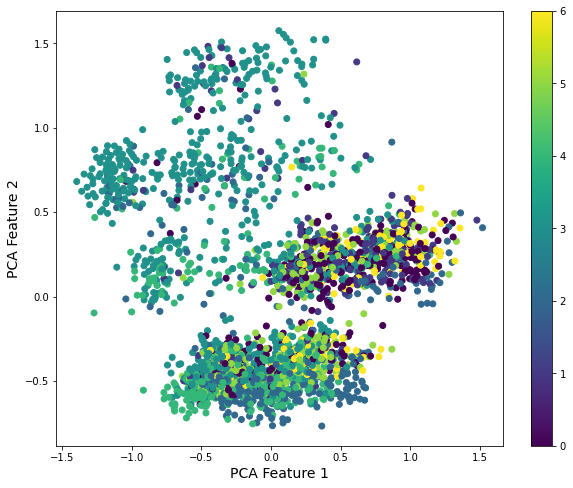

In [6]:
X_pca = pca_features(graph)
scatter_plot_pca(X_pca, graph.y.numpy())

In [7]:
def get_topology_matrices(graph):
    # adjacency matrix
    A = to_dense_adj(graph.edge_index, batch=None, edge_attr=None, max_num_nodes=graph.x.size(0)).squeeze().numpy()
    # symmetric normalized laplacian
    L_edge_index, L_edge_weight = get_laplacian(graph.edge_index, edge_weight=None, normalization="sym",
                                                num_nodes=graph.x.size(0))
    L = to_dense_adj(L_edge_index, batch=None, edge_attr=L_edge_weight, max_num_nodes=graph.x.size(0)).squeeze().numpy()
    # GCN convolution matrix
    C_edge_index, C_edge_weight = gcn_norm(graph.edge_index, edge_weight=None, 
                                           num_nodes=graph.x.size(0), improved=False, add_self_loops=True)
    C = to_dense_adj(C_edge_index, batch=None, edge_attr=C_edge_weight, max_num_nodes=graph.x.size(0)).squeeze().numpy()
    return A, L, C

def get_eigen_system(L):
    freqs, U = linalg.eigh(L)
    # clip numerical errors
    freqs = np.clip(freqs, 0, 2)
    return freqs, U

def spectral_magnitude(X, U):
    X_spec = U.transpose() @ X
    return np.linalg.norm(X_spec, axis=1)

def plot_magnitude(freqs, spec_mag, smooth_width=0.01):
    plt.figure(figsize=(10,6))
    plt.plot(freqs, spec_mag, label="Input Magnitude")
    smoothed_spec_mag = savgol_filter(spec_mag, int(len(freqs)*smooth_width), 3)
    plt.plot(freqs, smoothed_spec_mag, label="Smoothed Mean")
    plt.xlabel("Frequency", fontsize=14)
    plt.ylabel("Input Magnitude", fontsize=14)
    plt.xlim([0, 2])
    plt.show()
    
def gcn_spectral_filtering(C, X_in, nlayer=1, activation="ReLU", nrepeat=1):
    assert activation in ["ReLU", "sigmoid", None]
    if activation == "ReLU":
        sigma = lambda x: np.maximum(x, 0)
    elif activation == "sigmoid":
        sigma = lambda x: 1/(1 + np.exp(-x))
    elif activation is None:
        sigma = lambda x: x
    else:
        assert False
    nfeature = X_in.shape[1]
    X_out = np.zeros_like(X_in)
    for _ in range(nrepeat):
        X = X_in
        for l in range(nlayer):
            W = np.random.randn(nfeature, nfeature)/np.sqrt(nfeature)
            X = sigma(C @ X @ W)
        X_out += X
    return X_out/nrepeat

def plot_response(spec_mag_out, spec_mag_out_std, spec_mag_in, pred_responses):
    plt.figure(figsize=(10,6))
    plt.plot(freqs, spec_mag_out/spec_mag_in)
    plt.plot(freqs, pred_responses)
    plt.xlabel("Frequency", fontsize=14)
    plt.ylabel("Spectral Response (Relative Magnitude)", fontsize=14)
    plt.xlim([0, 2])
    plt.ylim([0, 1])
    plt.show()

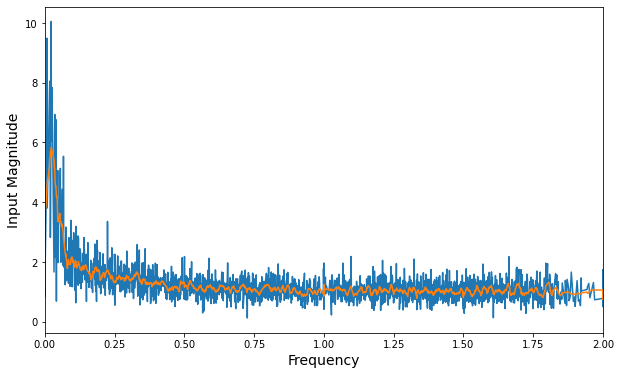

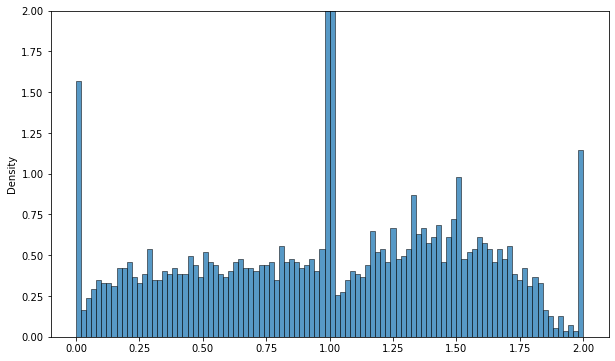

In [21]:
A, L, C = get_topology_matrices(graph)
freqs, U = get_eigen_system(L)
spec_mag_in = spectral_magnitude(X_pca, U)
plot_magnitude(freqs, spec_mag_in)
fig, ax = plt.subplots(figsize=(10,6))
sbs.histplot(freqs, stat='density', bins=100, ax=ax)
ax.set_ylim([0, 2])
plt.show()

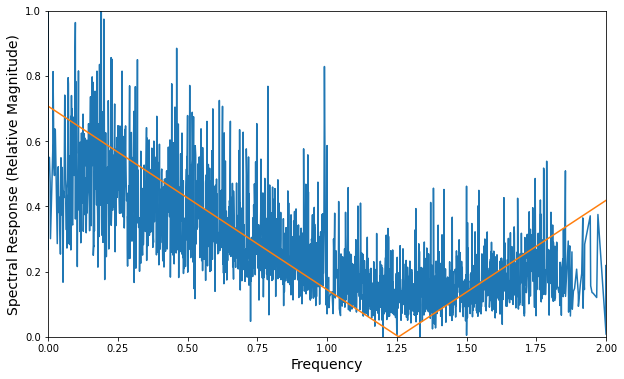

In [9]:
X_out = gcn_spectral_filtering(C, X_in=X_pca, nlayer=1, activation='ReLU', nrepeat=1)
spec_mag_out = spectral_magnitude(X_out, U)
pred_responses = gcn_response(size=graph.x.size(0), freqs=freqs, avg_deg=graph.edge_index.size(1)/graph.x.size(0), nlayer=1)
plot_response(spec_mag_out, None, spec_mag_in, pred_responses)

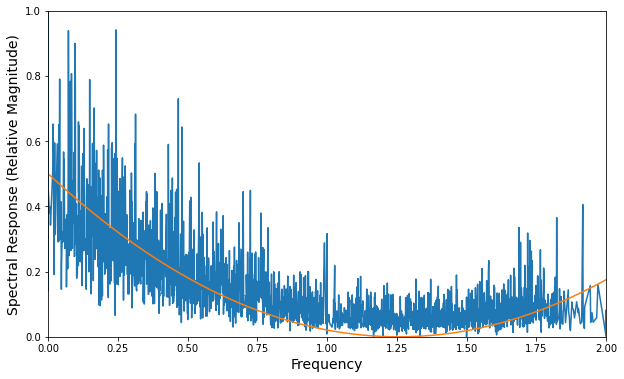

In [10]:
X_out = gcn_spectral_filtering(C, X_in=X_pca, nlayer=2, activation='ReLU', nrepeat=1)
spec_mag_out = spectral_magnitude(X_out, U)
pred_responses = gcn_response(size=graph.x.size(0), freqs=freqs, avg_deg=graph.edge_index.size(1)/graph.x.size(0), nlayer=2)
plot_response(spec_mag_out, None, spec_mag_in, pred_responses)

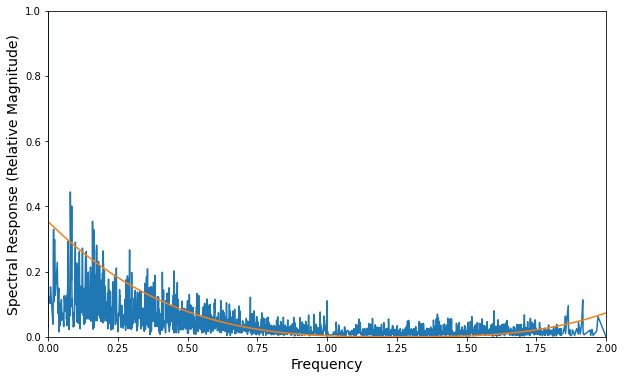

In [11]:
X_out = gcn_spectral_filtering(C, X_in=X_pca, nlayer=3, activation='ReLU', nrepeat=1)
spec_mag_out = spectral_magnitude(X_out, U)
pred_responses = gcn_response(size=graph.x.size(0), freqs=freqs, avg_deg=graph.edge_index.size(1)/graph.x.size(0), nlayer=3)
plot_response(spec_mag_out, None, spec_mag_in, pred_responses)